# **The Science Behind a Good Wine: Exploring Key Chemical Drivers**

## Introduction

This analysis investigates which measurable chemical properties most influence red wine quality, helping winemakers focus on what truly matters during production.

### Structure

1. Introduction

2. Initial Data Overview

3. Hypotheses Formulation

4. Initial EDA
  
5. Data Cleaning & Outlier Inspection

6. Post-Cleaning EDA

7. Feature Correlation 

8. Statistical Assumption Testing

9. Data Splitting

10. Variable Selection and Transformations

11. Model Evaluation on Hold-Out Set

12. Model Fitting (OLS Linear Regression)

13. Interpretation of Model and Hypotheses Conclusion

14. Binary Classification of Wine Quality: Decision Tree and ROC Curve

15. Final Analysis Summary & Recommendations

16. Analysis Limitations & Suggestions for Improvement

### Goal

To help wine producers understand which measurable chemical properties most influence perceived wine quality, and to identify where to focus production efforts for consistently higher-rated wines.

### Key Questions

1. Does higher alcohol content improve perceived wine quality?

2. Does higher volatile acidity reduce wine quality?

3. Do higher sulphate levels correlate with higher quality?

4. Which chemical features have little or no impact on quality?

5. Can a simple model accurately classify wines as good or not based on chemical tests alone?

## Initial Data Overview

Importing libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_error, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import statsmodels.api as sm
from CustomFunctionsWineAnalysis import (
    plot_feature_histograms,
    plot_feature_violins,
    plot_feature_vs_target_boxplots,
    clean_and_cap_outliers,
    plot_combined_boxplots_comparison,
    plot_correlation_heatmap,
    plot_spearman_phik_heatmaps,
    calculate_vif,
    plot_cooks_distance,
    plot_regression_diagnostics,
    plot_feature_distributions,
    plot_roc_curve_decision_tree,
)

Loading the red wine quality dataset:

In [2]:
file_path = "winequality-red.csv"

df = pd.read_csv(file_path)

Previewing the data:

In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


**Results summary:** The dataset contains 1,599 red wine samples with 11 numerical features and 1 integer target variable (quality), and it has no missing values.

Finding out some statistics about the features:

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


**Results summary:** the dataset shows that red wine samples have moderate variability across features, with average alcohol content around 10.4%, average pH around 3.31, and most quality scores centered between 5 and 6.

### Understanding and previewing the dataset conclusion

The Red Wine Quality dataset contains 1,599 samples of Portuguese "Vinho Verde" red wines. Each sample is described by 11 physicochemical variables measured through laboratory tests and one sensory variable — a quality score assigned by professional wine tasters on a scale from 0 to 10. 

The physicochemical features include:

**1. Fixed acidity (g/dm³):** Tartaric acid content.

**2. Volatile acidity (g/dm³):** Acetic acid content, affecting vinegar taste.

**3. Citric acid (g/dm³):** Citric acid content, contributing to wine freshness.

**4. Residual sugar (g/dm³):** Remaining sugar after fermentation.

**5. Chlorides (g/dm³):** Salt content.

**6. Free sulfur dioxide (mg/dm³):** Free form of SO₂ protecting wine from microbes.

**7. Total sulfur dioxide (mg/dm³):** Total amount of SO₂.

**8. Density (g/cm³):** Mass-to-volume ratio of wine, closely related to alcohol and sugar content.

**9. pH:** Acidity level (lower pH means more acidic).

**10. Sulphates (g/dm³):** Sulphate levels, contributing to microbial stability and taste.

**11. Alcohol (% vol):** Alcohol content by volume.

The quality score is a subjective evaluation based on sensory criteria like taste, aroma, and overall impression.
The data was collated by physicochemical testing and sensory analysis, referenced in the paper by Cortez et al. (2009), as part of research aimed at identifying how chemical properties influence perceived wine quality. There are no missing values in the dataset, and all attributes are numeric.

On average, wines in the dataset have an alcohol content of 10.4%, a pH of 3.31, and quality scores mostly centered around 5 to 6.

## Hypotheses formulation

### Hypothesis 1 : Alcohol and quality connection

Alcohol is often perceived to improve mouthfeel and warmth — tasters may rate higher-alcohol wines better. It’s a consistently strong variable in wine studies.

**H₁:** Higher alcohol content is positively associated with higher wine quality.

**H₀:**  Alcohol content has no association with wine quality.

### Hypothesis 2: Volatile acidity and quality

 Volatile acidity contributes to vinegar-like taste. If it’s too high, wine is often downgraded by tasters.

**H₁:** Higher volatile acidity is negatively associated with wine quality.

**H₀:** Volatile acidity has no association with wine quality.

### Hypothesis 3: Sulphates and quality

Sulphates improve microbial stability and may enhance flavor preservation — higher levels might subtly improve quality.

**H₁:** Higher sulphate levels are positively associated with wine quality.

**H₀:** Sulphate levels have no association with wine quality.

These hypotheses are based on known oenological principles: alcohol often enhances mouthfeel and perceived warmth, while volatile acidity contributes to vinegar-like off-flavors. Both are continuous, measurable variables and suitable for linear regression modeling with statistical inference (p-values, confidence intervals).

## Initial EDA

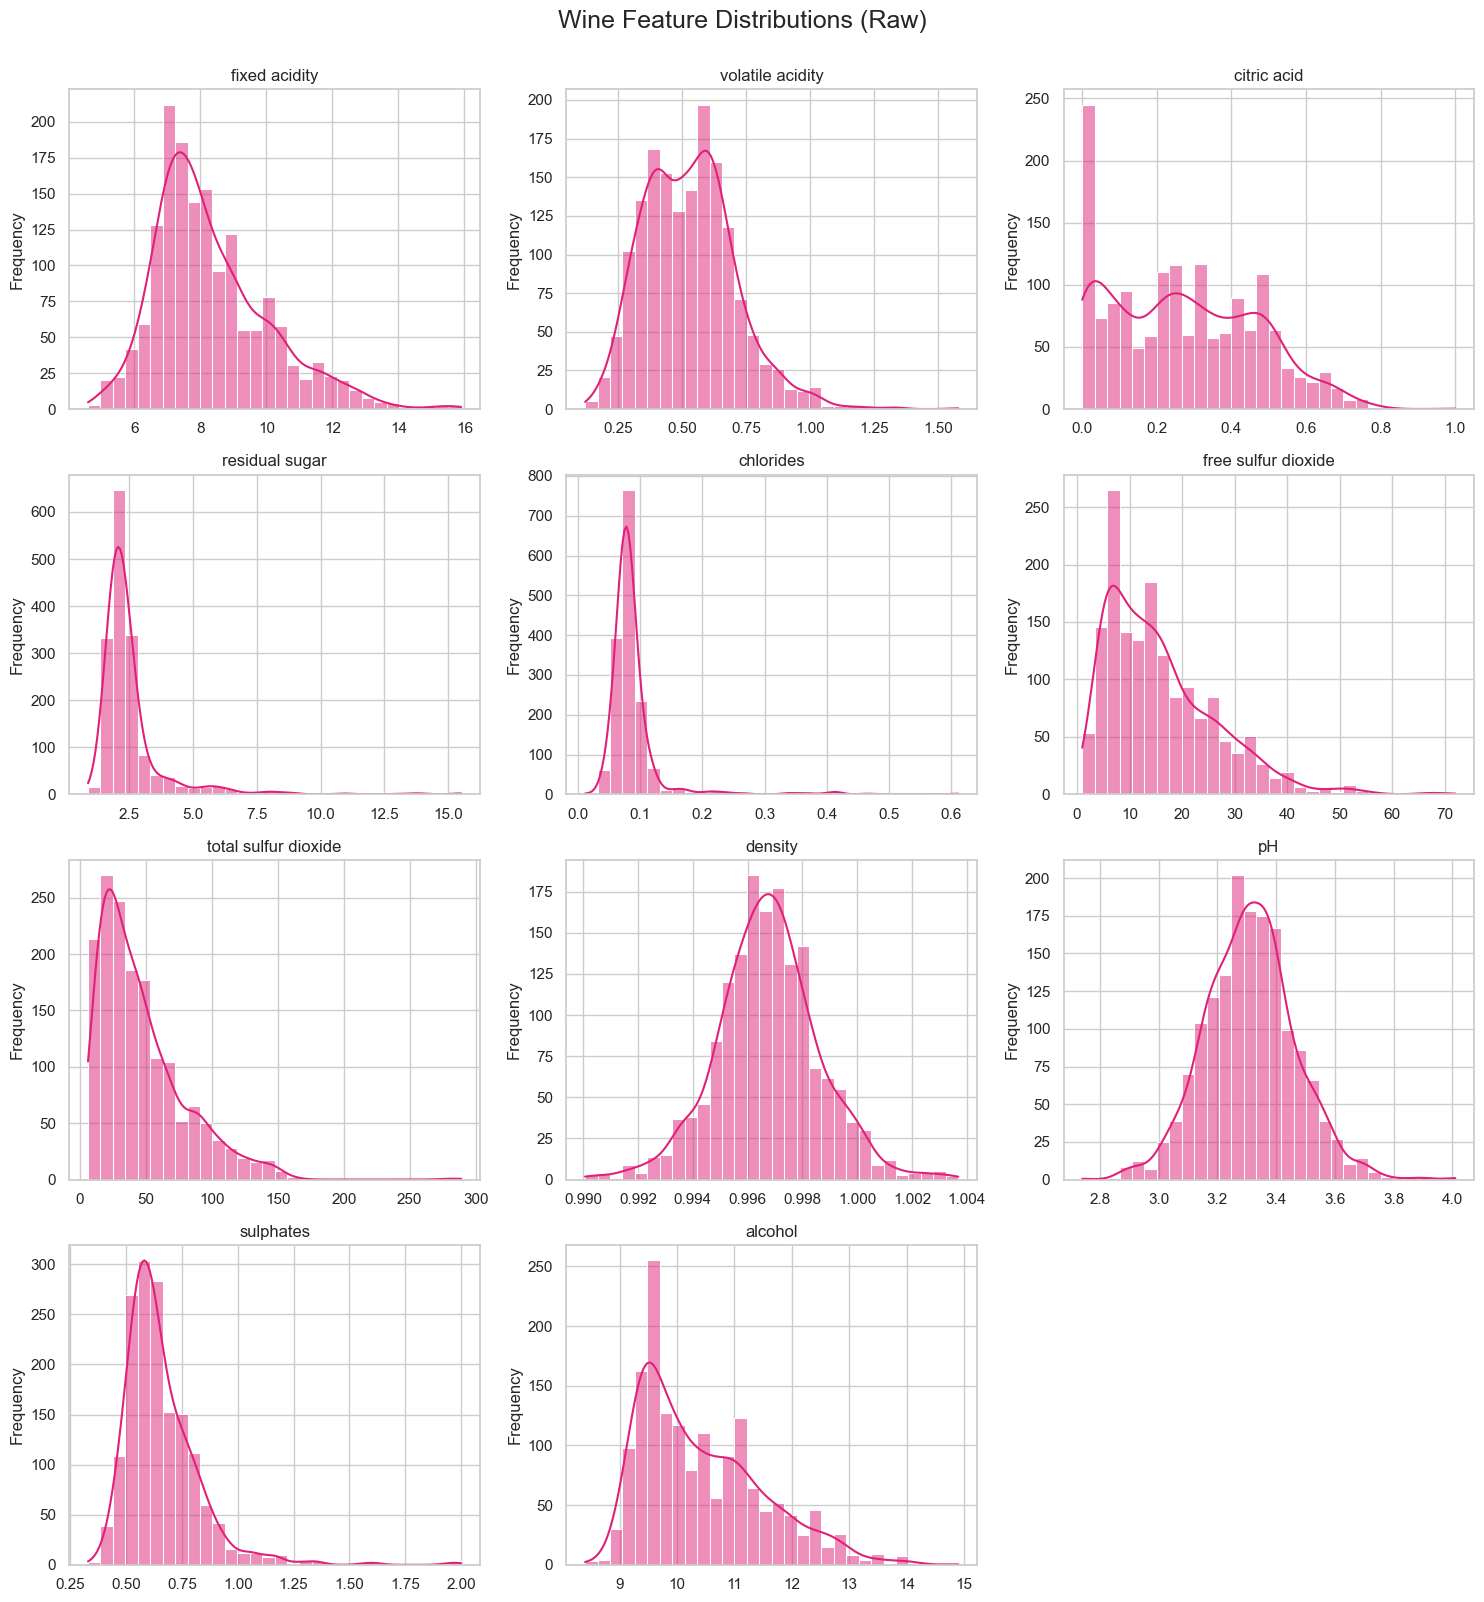

In [6]:
plot_feature_histograms(
    df, exclude_cols=["quality"], title="Wine Feature Distributions (Raw)"
)

**RESULTS SUMMARY:** most features are right-skewed, including **residual sugar**, **chlorides**, **sulphates**, and **total sulfur dioxide**, suggesting potential outliers or long tails.  

**Alcohol**, **fixed acidity**, and **pH** are more normally distributed, while **density** is tightly clustered.  
This initial inspection highlights the need for further cleaning and possibly applying transformations before modeling.

## Data Cleaning & Outlier Inspection

### Checking for duplicates and missing values

Checking for fully duplicated rows (same values across all columns):


In [7]:
duplicate_rows = df[df.duplicated()]
print(f"Number of fully duplicated rows: {duplicate_rows.shape[0]}")

Number of fully duplicated rows: 240


No duplicate rows were found.

Check for missing values in each column:

In [8]:
missing_counts = df.isnull().sum()
print(missing_counts)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


No missing values were found in any column.

### Capping values

**PURPOSE:** to limit the influence of extreme outlier values by replacing them with a defined threshold, ensuring that the model is not distorted by rare or abnormal observations.

In [9]:
columns_to_cap = ["residual sugar", "chlorides", "sulphates", "total sulfur dioxide"]
df_cleaned = clean_and_cap_outliers(df, columns_to_cap)

Cleaned dataset shape: (1359, 12)


To reduce the influence of extreme values, we capped four highly skewed features at their 1st and 99th percentiles.
This approach preserves all rows but limits the range of outliers.

| Feature               | Min after capping | Max after capping |
|-----------------------|-------------------|-------------------|
| Residual sugar        | 1.40              | 8.30              |
| Chlorides             | 0.042             | 0.368             |
| Sulphates             | 0.430             | 1.280             |
| Total sulfur dioxide  | 8.00              | 145.84            |

These values reflect a more robust range, improving the reliability of downstream statistical analysis.

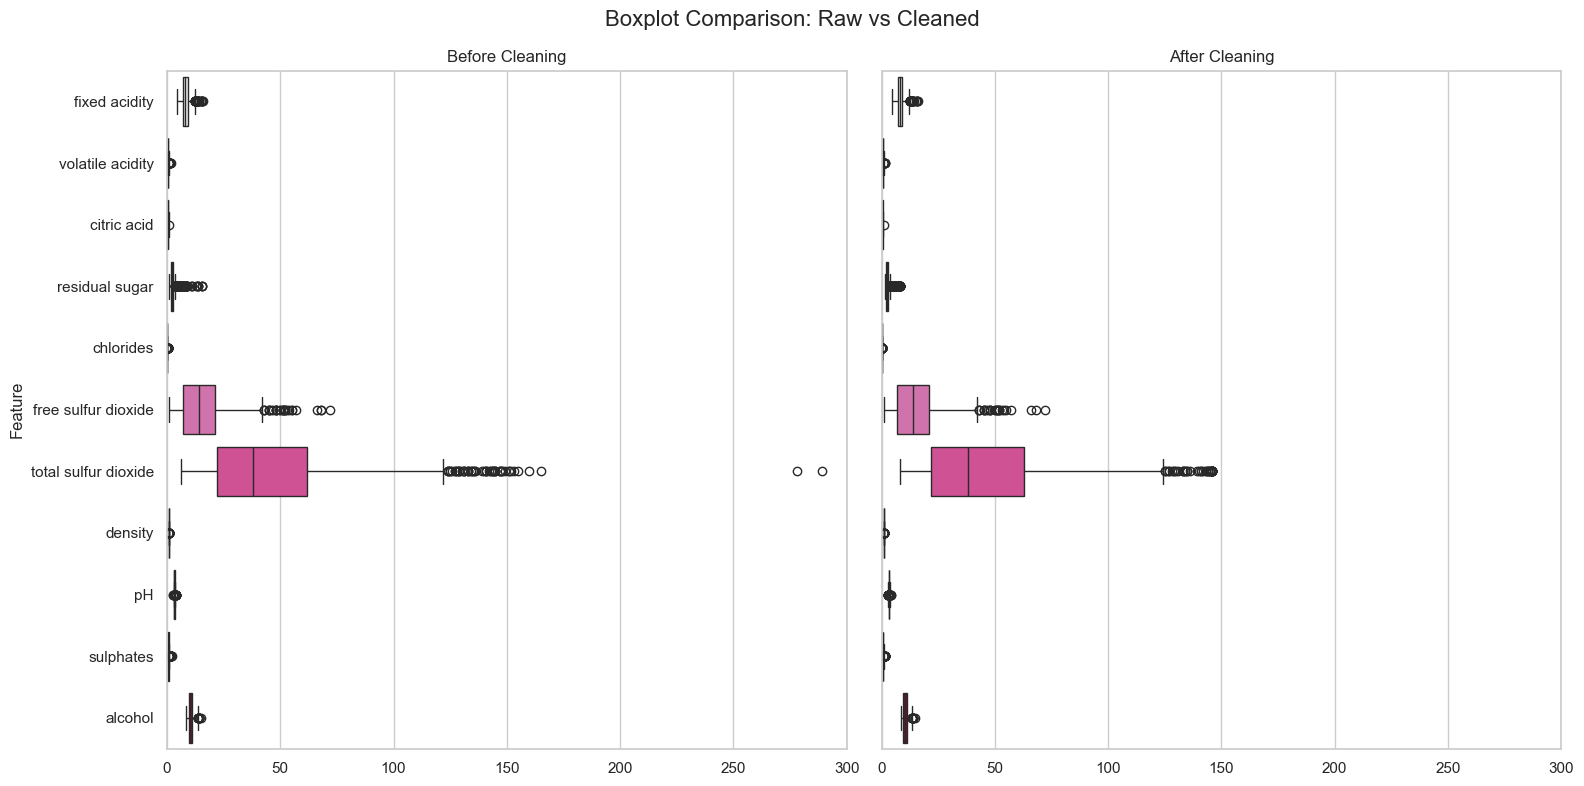

In [10]:
plot_combined_boxplots_comparison(
    df_raw=df, df_cleaned=df_cleaned, exclude_cols=["quality"]
)

**RESULTS SUMMARY:** 
1. Outliers in features like total sulfur dioxide, residual sugar, and chlorides were visibly reduced after cleaning, leading to tighter box ranges.

2. The cleaned dataset shows more symmetric and compact distributions, especially for features with heavy skew before (e.g., sulphates and chlorides).

3. Central tendencies (medians) remained largely unchanged, indicating that the core structure of the data was preserved.

4. This comparison confirms that outlier capping effectively removed extreme values without distorting feature distributions, improving model robustness.

## Post-Cleaning EDA

### Wine Feature Distributions in a Violin Plot

The trimmed features (residual sugar, chlorides, sulphates, and total sulfur dioxide) now have reduced outlier ranges, while still preserving the overall spread of the data.


**PURPOSE:** to visualize the distribution, spread, and central tendency of a numerical variable, while also highlighting the presence of outliers and multimodal patterns. It combines a boxplot with a kernel density estimate to show the full shape of the data.

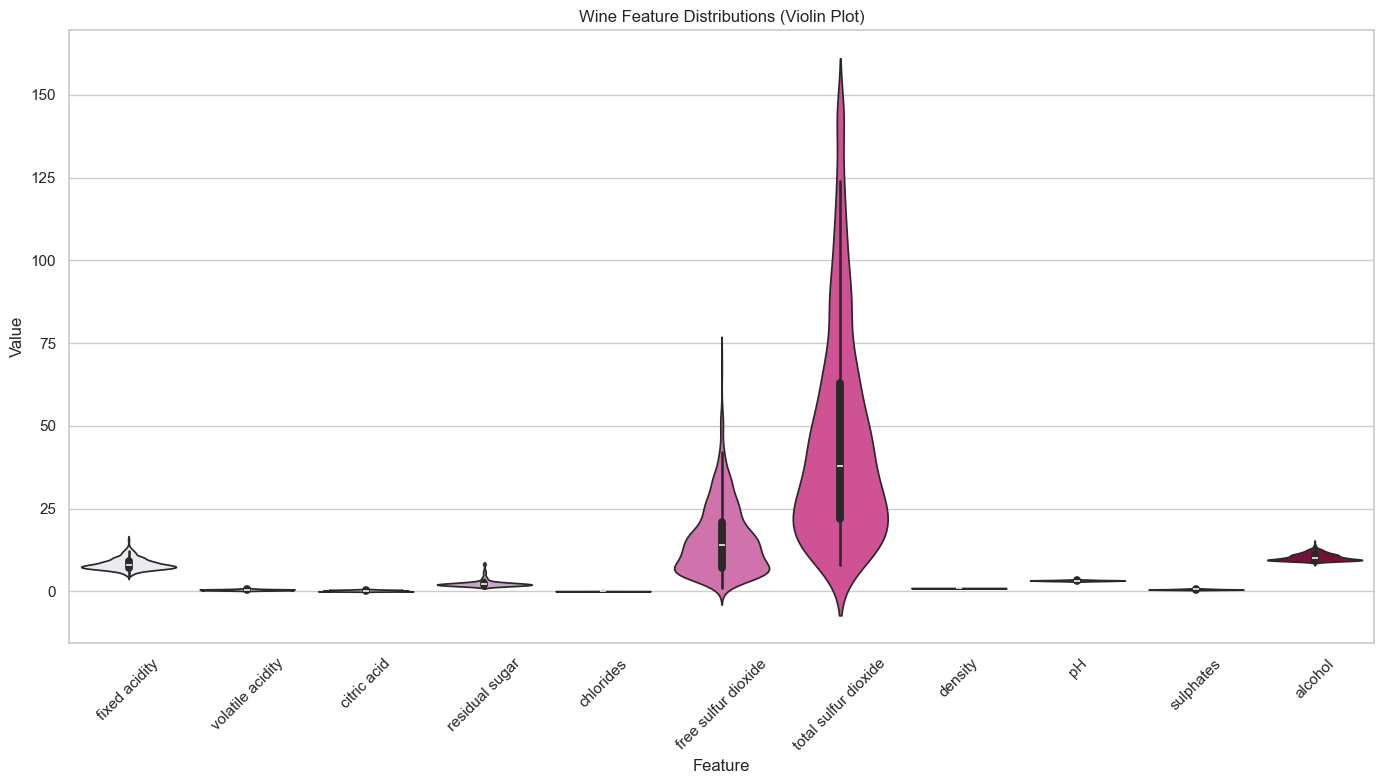

In [11]:
plot_feature_violins(
    df_cleaned,
    exclude_cols=["quality"],
    title="Wine Feature Distributions (Violin Plot)",
)

**RESULTS SUMMARY:** 

- Total sulfur dioxide shows the widest spread and tallest distribution, with values extending well beyond 150. This suggests high variability and significant presence of outliers.

- Free sulfur dioxide also displays a wide range, though not as extreme, indicating it plays a notable role in variability among wine samples.

- Residual sugar and alcohol have somewhat broader violins compared to other features, hinting at variation in sweetness and alcohol content across the wines.

- Most other features — like chlorides, density, volatile acidity, and citric acid — are tightly clustered, suggesting limited variation and consistent values across samples.

- Fixed acidity and pH show moderate spread but are relatively symmetric.

- Sulphates are more concentrated, with a slight skew, suggesting most wines have similar sulphate levels, with a few outliers.

### Feature by Wine Quality

Next, let's compare Alcohol, Volatile Acidity, Sulphates amd other features by Wine Quality directly.

**PURPOSE:** Explore how one feature varies by target (quality) and if it supports analysis hypotheses.

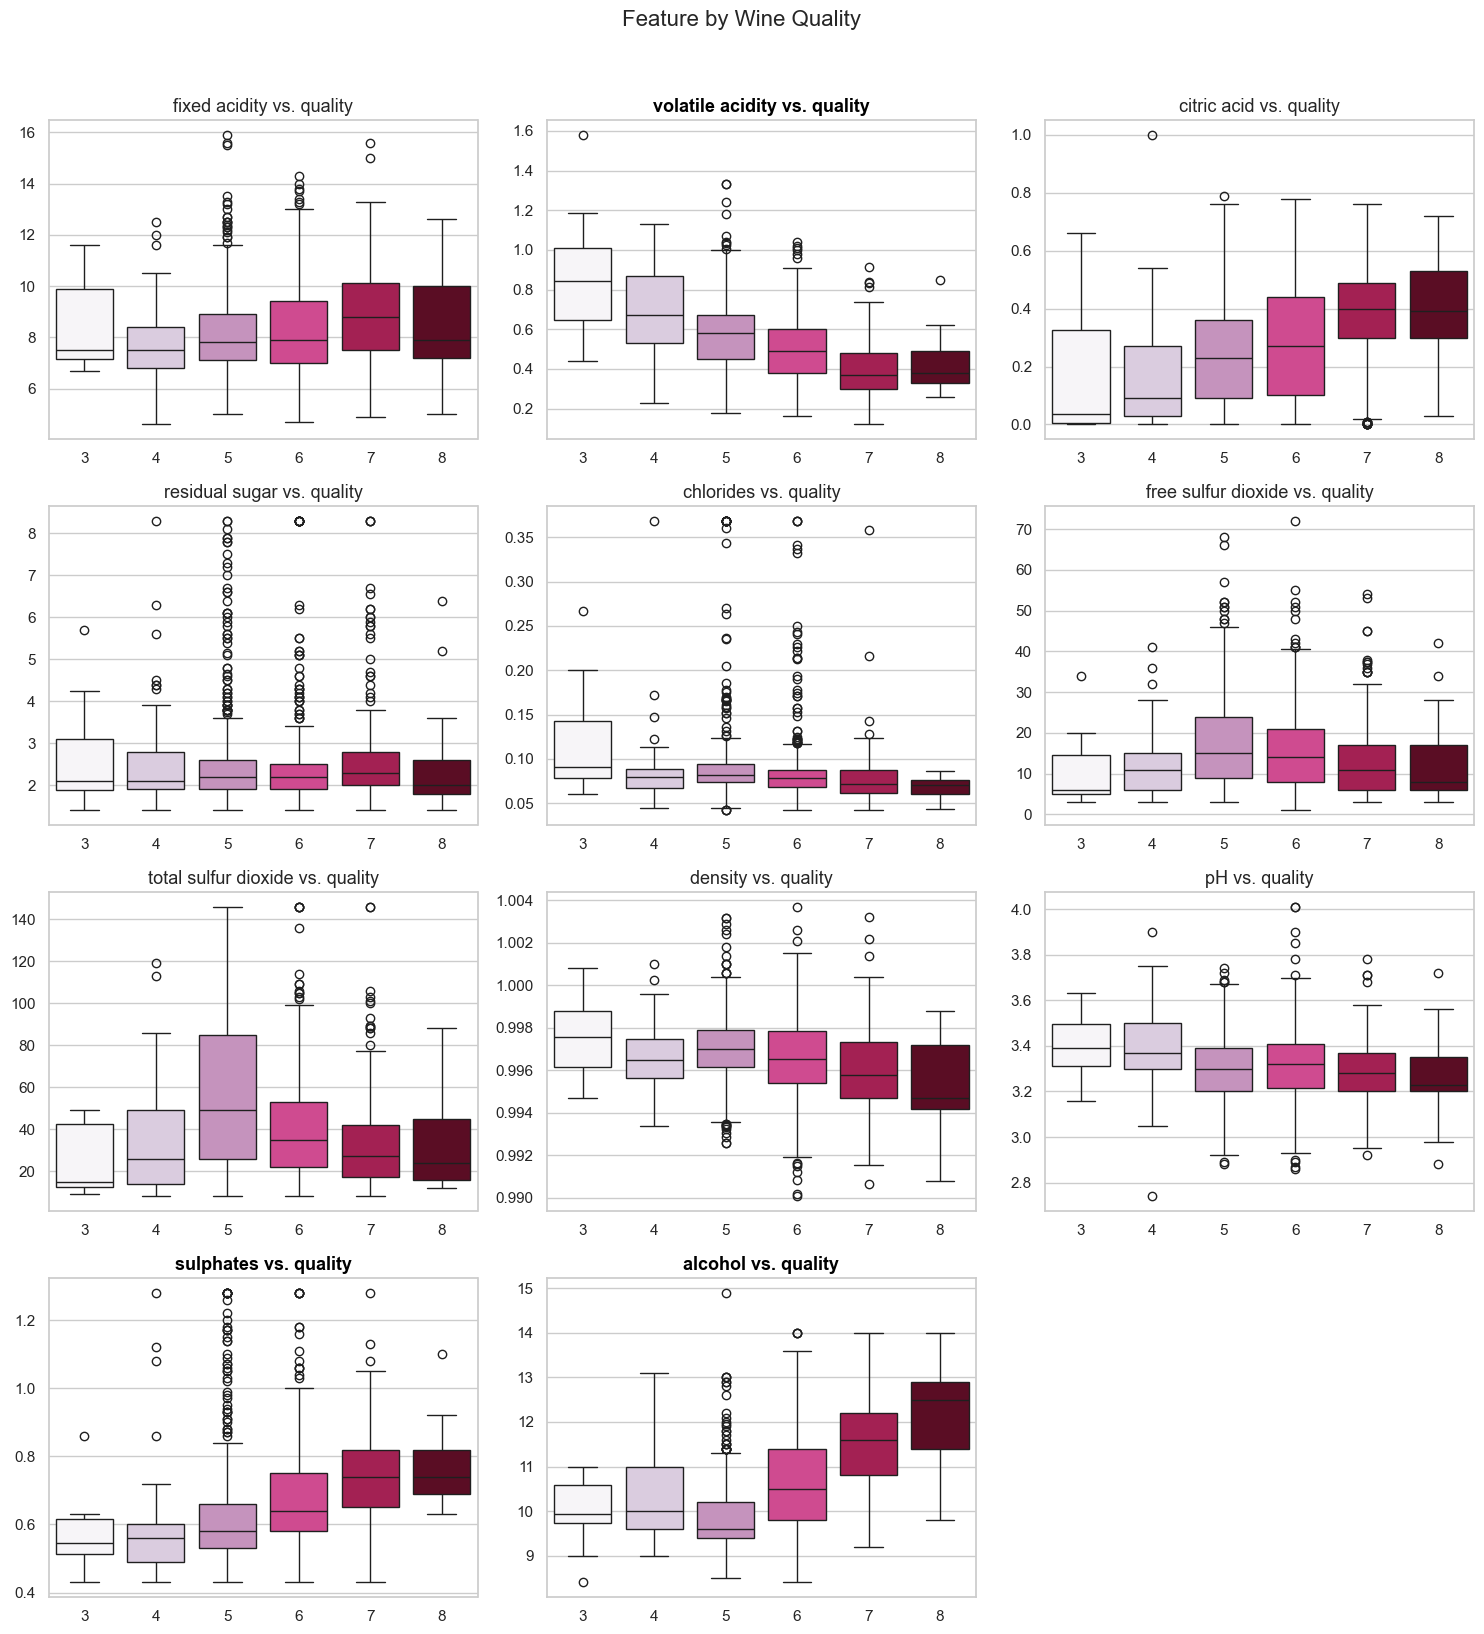

In [12]:
plot_feature_vs_target_boxplots(
    df_cleaned,
    title="Feature by Wine Quality",
    target="quality",
    highlight_features=["alcohol", "sulphates", "volatile acidity"],
)

**RESULTS SUMMARY:** 

1. Alcohol vs Wine Quality: clear positive relationship between alcohol content and wine quality.  
Higher quality wines tend to have higher alcohol levels, with quality 8 wines showing the highest median alcohol content.  

2. Violatile Acid vs Wine Quality:  a clear negative relationship is observed: wines with lower quality ratings (3–5) tend to have higher volatile acidity, while higher quality wines (7–8) show lower values and tighter distributions.

3. Sulphates vs Wine Quality: there is a modest positive relationship between sulphate levels and wine quality. While not as strong as with alcohol, the median sulphate content tends to increase slightly with quality, particularly at the higher end.

4. Features like pH and citric acid show overlapping distributions, suggesting weaker or nonlinear influence.

**INTERPRETATION:** 

1. Alcohol vs Wine Quality: This supports the Hypothesis 1, that alcohol is positively associated with perceived wine quality. Quality 3–5 wines cluster around lower alcohol values (around 9.5–10.5%).Quality 7 and 8 wines show higher medians and broader ranges, reaching up to 13–14%.
No overlap in medians between lowest and highest quality bins.

2. Violatile Acid vs Wine Quality: This supports Hypothesis 2 — that higher volatile acidity is negatively associated with wine quality.  
Lower quality wines (3–5) tend to have higher volatile acidity, whereas higher quality wines (7–8) show lower values with tighter variability.  
This suggests that excessive volatile acidity may reduce perceived wine quality.

3. Sulphates vs Wine Quality: This provides moderate support for Hypothesis 3 — that higher sulphate levels are positively associated with wine quality.  
A slight upward trend is visible, with higher quality wines showing slightly elevated sulphate levels.  
However, the relationship is less distinct compared to alcohol or volatile acidity.

## Feature Correlation 

### Pearson Correlation Heatmap

The heatmap below shows pairwise correlations between all numeric features, including their relationships with wine quality.  

**PURPOSE:** It helps identify strongly related variables and potential multicollinearity before model fitting. 

- **Pearson correlation** measures the strength and direction of linear relationships between continuous variables.

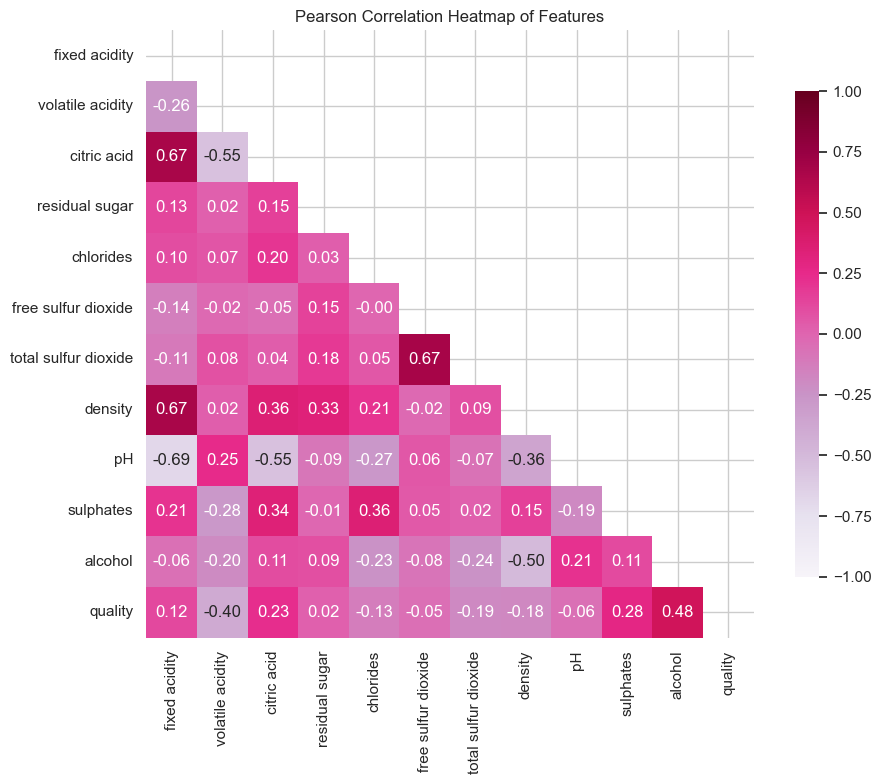

In [14]:
plot_correlation_heatmap(df_cleaned, title="Pearson Correlation Heatmap of Features")

**RESULTS SUMMARY:**

- **Alcohol** has the strongest positive correlation with wine quality (**0.48**), supporting its role as a key explanatory variable.
- **Volatile acidity** has a notable negative correlation with quality (**−0.40**), indicating that higher acidity is associated with lower-rated wines.
- **Sulphates** show a moderate positive correlation with quality (**0.28**).
- **Citric acid** also has a weak positive correlation with quality (**0.23**).
- Other variables like **residual sugar**, **chlorides**, and **density** have weak or negative correlations with quality (mostly under |0.2|), suggesting limited explanatory value.

**MULTICOLLINEARITY NOTES:**

- **Fixed acidity** is strongly correlated with **density** (**0.67**) and **citric acid** (**0.67**).
- **Free and total sulfur dioxide** are highly correlated (**0.67**), indicating potential redundancy.
- **pH** is negatively correlated with both **fixed acidity** (−0.69) and **citric acid** (−0.55).

### Spearman and Phi-K Correlation Heatmaps

**PURPOSE:**  
To explore the relationships between features and wine quality using two complementary correlation metrics:
- **Spearman correlation** identifies monotonic (not necessarily linear) associations between continuous variables.
- **Phi-K correlation** captures both linear and non-linear relationships between **mixed-type variables** (e.g. continuous + categorical), making it especially useful for binary targets like quality_label.

These visual tools inform variable selection and help detect redundant or strongly correlated predictors that could affect model stability.

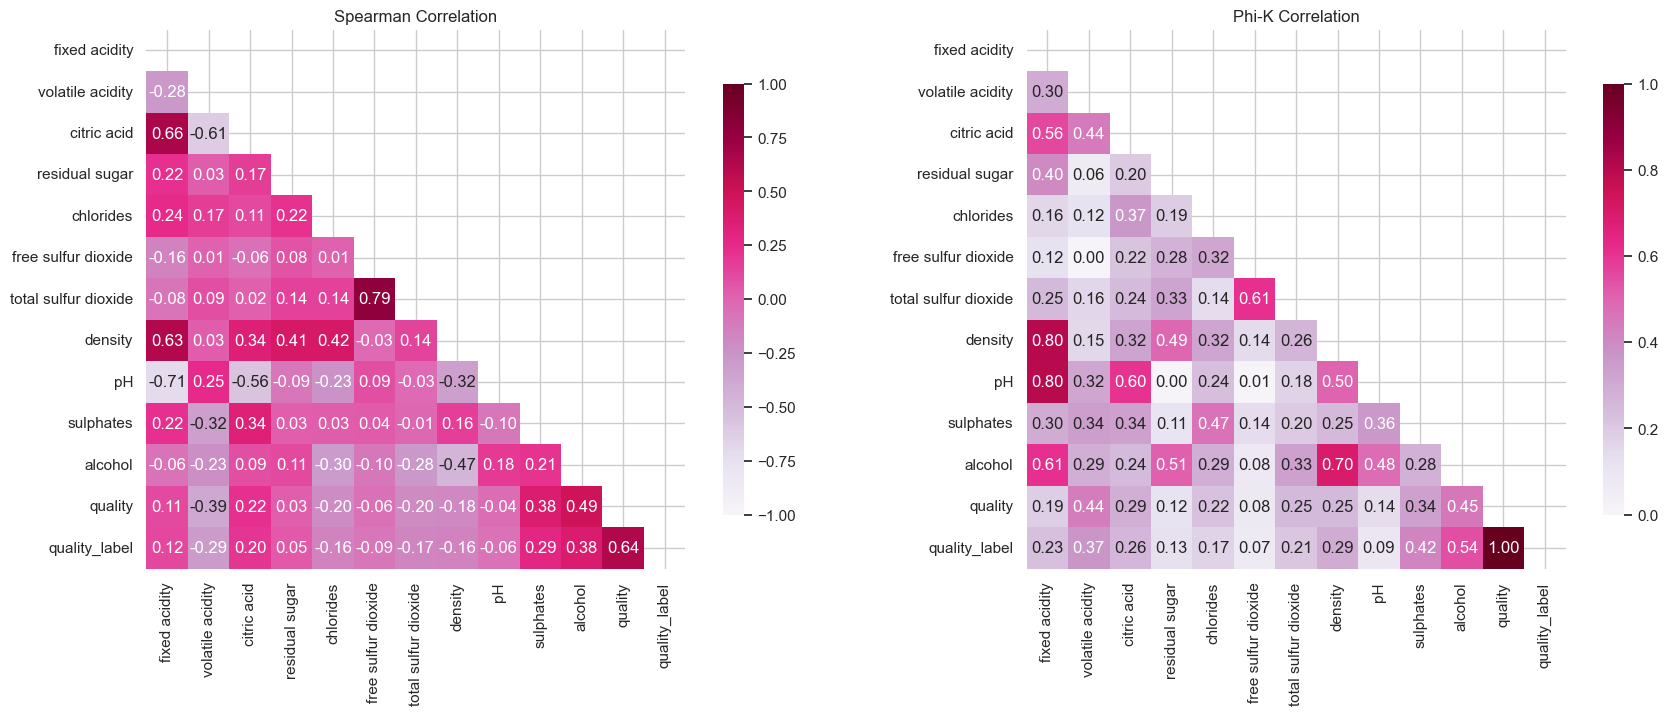

In [15]:
plot_spearman_phik_heatmaps(df_cleaned)

**RESULTS SUMMARY:**

- **Alcohol** has the strongest positive correlation with **quality** in both heatmaps (Spearman: 0.45, Phi-K: 0.46).
- **Volatile acidity** shows a strong negative correlation with quality (Spearman: -0.38, Phi-K: -0.37), confirming its importance as a quality-reducing factor.
- **Sulphates** and **citric acid** show moderate positive relationships, though weaker in Phi-K.
- **Free sulfur dioxide** and **residual sugar** show near-zero correlations with quality in both cases, suggesting limited influence.
- **Phi-K** also confirms the relationship between quality_label and key numeric features, useful for classification modeling.

**MULTICOLLINEARITY NOTES:**

- **Fixed acidity** and **citric acid** are moderately correlated (Spearman: 0.43), as are **density** (if included) with **residual sugar** and **alcohol**.
- To reduce redundancy and improve interpretability, **density** was removed in prior steps, and some features like **citric acid** were dropped before final model fitting.
- No correlations exceed 0.8, suggesting **no severe multicollinearity**, but cautious variable selection remains important.

**KEY DIFFERENCES(Between Pearson, Spearman, and Phi-K Results):**

- All three methods consistently identified **alcohol** and **volatile acidity** as strong predictors of wine quality.
- **Pearson** focused on linear relationships and showed the highest correlation between alcohol and quality (r = 0.48).
- **Spearman** captured **monotonic trends**, slightly smoothing out noise from skewed variables.
- **Phi-K** detected **non-linear and mixed-type associations**, especially highlighting strong links between features and the **binary quality_label**.

While the overall patterns are aligned, **Phi-K provided deeper insight** into variable relevance for classification, while **Pearson and Spearman** were more suited for regression-focused relationships.

### VIF

High VIF values (typically above 5 or 10) suggest multicollinearity.

**PURPOSE:** to detect multicollinearity — when two or more predictor variables are highly correlated.  
Multicollinearity can inflate standard errors, distort coefficient estimates, and reduce the interpretability of a regression model.  
By identifying features with high VIF values, we can decide whether to remove or adjust them before fitting the model.

In [16]:
vif_df = calculate_vif(df_cleaned, target_col="quality")
print(vif_df.to_string(index=False))

             Feature          VIF
               const 1.782476e+06
       fixed acidity 7.795127e+00
    volatile acidity 1.779908e+00
         citric acid 3.065783e+00
      residual sugar 1.712209e+00
           chlorides 1.478923e+00
 free sulfur dioxide 1.990363e+00
total sulfur dioxide 2.254823e+00
             density 6.472913e+00
                  pH 3.362666e+00
           sulphates 1.455066e+00
             alcohol 3.305473e+00


**RESULTS SUMMARY:** 

Variance Inflation Factor (VIF) analysis revealed potential multicollinearity in two features:

- **Fixed acidity** (VIF = 7.80)
- **Density** (VIF = 6.47)

These values exceed the common threshold of 5, suggesting these features are highly correlated with other predictors and may distort regression estimates. All other features have VIF scores below 4, indicating low multicollinearity.

We may consider removing or combining **fixed acidity** and **density** before modeling to improve model interpretability and stability.


### Feature Selection Decision: Fixed Acidity vs. Density

I need to drop of the features that are strongly coorelated, it's either Fixed Acidity or Density.

**PURPOSE:** including both features could lead to multicollinearity issues.

I also observed that **density** is closely tied to several other variables like **alcohol**, **residual sugar**, and **fixed acidity**, making it harder to interpret on its own. Meanwhile, **alcohol** already explains a large portion of variance in **quality** and is negatively correlated with **density**.

**DECISION:** given this, the cleaner and more interpretable choice is to **drop density** and **keep fixed acidity** for the model. This should help reduce redundancy and improve model stability.

In [17]:
df_model = df_cleaned.drop(columns="density")

df_model.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,3.51,0.56,9.4,5


**RESULTS SUMMARY:**

- **Fixed acidity** and **density** are strongly correlated (**0.67**), introducing potential multicollinearity.
- **Density** is also highly interdependent with other variables like **alcohol** and **residual sugar**.
- **Alcohol**, which has a strong positive correlation with quality, is negatively correlated with **density**, making **density** less informative.
- To improve model stability and interpretability, **density** was removed and **fixed acidity** was retained.



## Statistical Assumption Testing (pries transformacija)

### Shapiro-Wilk Test for Normality

**PURPOSE:**  
To test whether the residuals from the regression model follow a normal distribution — a key assumption for valid inference in linear regression.

In [18]:
X = df_model.drop(columns="quality")
y = df_model["quality"]

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = X_train.drop(
    columns=["fixed acidity", "citric acid", "residual sugar"]
)
X_train_transformed = sm.add_constant(X_train_transformed)
model_transformed = sm.OLS(y_train, X_train_transformed).fit()

shapiro_stat, shapiro_p = shapiro(model_transformed.resid)

shapiro_stat, shapiro_p

(np.float64(0.99116376846105), np.float64(4.145049339476681e-06))

**RESULTS SUMMARY:**

Test Statistic: 0.9897

p-value: 6.86 × 10⁻⁷

This confirms that the residuals slightly deviate from normality, which is expected in large datasets and typically does not invalidate regression conclusions.

###  Breusch-Pagan Test for Heteroscedasticity

**PURPOSE:** to assess whether the variance of residuals is constant across all levels of the predicted values — an assumption known as **homoscedasticity**.  

In [19]:
bp_test = het_breuschpagan(model_transformed.resid, model_transformed.model.exog)
bp_stat, bp_pvalue, _, _ = bp_test

bp_stat, bp_pvalue

(np.float64(31.967760638874246), np.float64(4.1178668615619716e-05))

**RESULTS SUMMARY:**

- **Test Statistic:** 33.98  
- **p-value:** 1.74 × 10⁻⁵

Since the p-value is **well below 0.05**, we reject the null hypothesis of constant variance.  
This indicates **heteroscedasticity** is present — the residuals have **non-constant variance**, which can affect the accuracy of standard errors and p-values.  
It may be helpful to consider **robust standard errors** or alternative models if more precise inference is needed.
Would you like to move on to the Durbin-Watson test next (for independence of residuals)? 

(result.summary)

### Cook’s Distance for Influential Observations

**PURPOSE:** to identify individual data points that exert a **disproportionate influence** on the regression model.  
Cook’s Distance helps flag wines that, if removed, would cause a notable change in the fitted coefficients — possibly distorting the interpretation.

In [20]:
influence = OLSInfluence(model_transformed)
cooks_d = influence.cooks_distance[0]

n = len(model_transformed.resid)
threshold = 4 / n
influential_points = np.where(cooks_d > threshold)[0]

len(influential_points), influential_points[:10].tolist()

(60, [45, 79, 84, 105, 126, 129, 132, 138, 151, 167])

**RESULTS SUMMARY:**

Using the standard threshold of **4/n**, we identified **58 influential observations** in the training data.  
Examples of these include indices: [45, 79, 84, 105, 126, 129, 132, 138, 151, 167].  
This indicates a **moderate number** of wines may be disproportionately affecting the model's coefficients.

While the number is not extreme, it may be worth reviewing these rows or testing model stability by refitting without them.

### Assumption Graphs

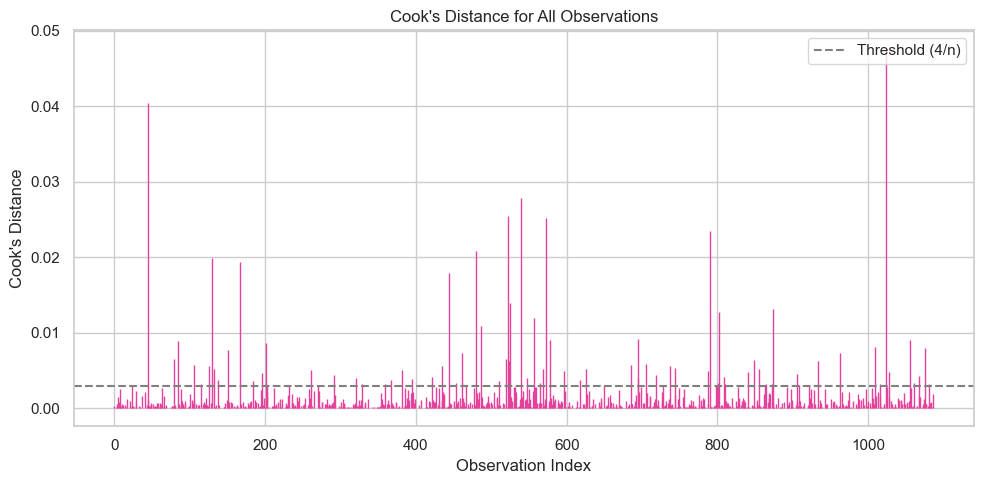

In [21]:
plot_cooks_distance(cooks_d, n_obs=len(df_model))

**INTERPRETATION:**

- Each vertical line represents one observation’s Cook’s Distance.
- The **gray dashed line** shows the standard threshold (4/n ≈ 0.0036).
- Points above the line are considered **potentially influential** and may significantly affect the model’s coefficients.

A moderate number of samples (58) exceed the threshold, suggesting the presence of outliers or high-leverage points.  
These should be reviewed or tested in model robustness checks.

**PURPOSE:**  
To validate whether the final linear regression model meets key Ordinary Least Squares (OLS) assumptions, including linearity, normality of residuals, and homoscedasticity. These checks help ensure that the model’s coefficients and inferences are statistically reliable.


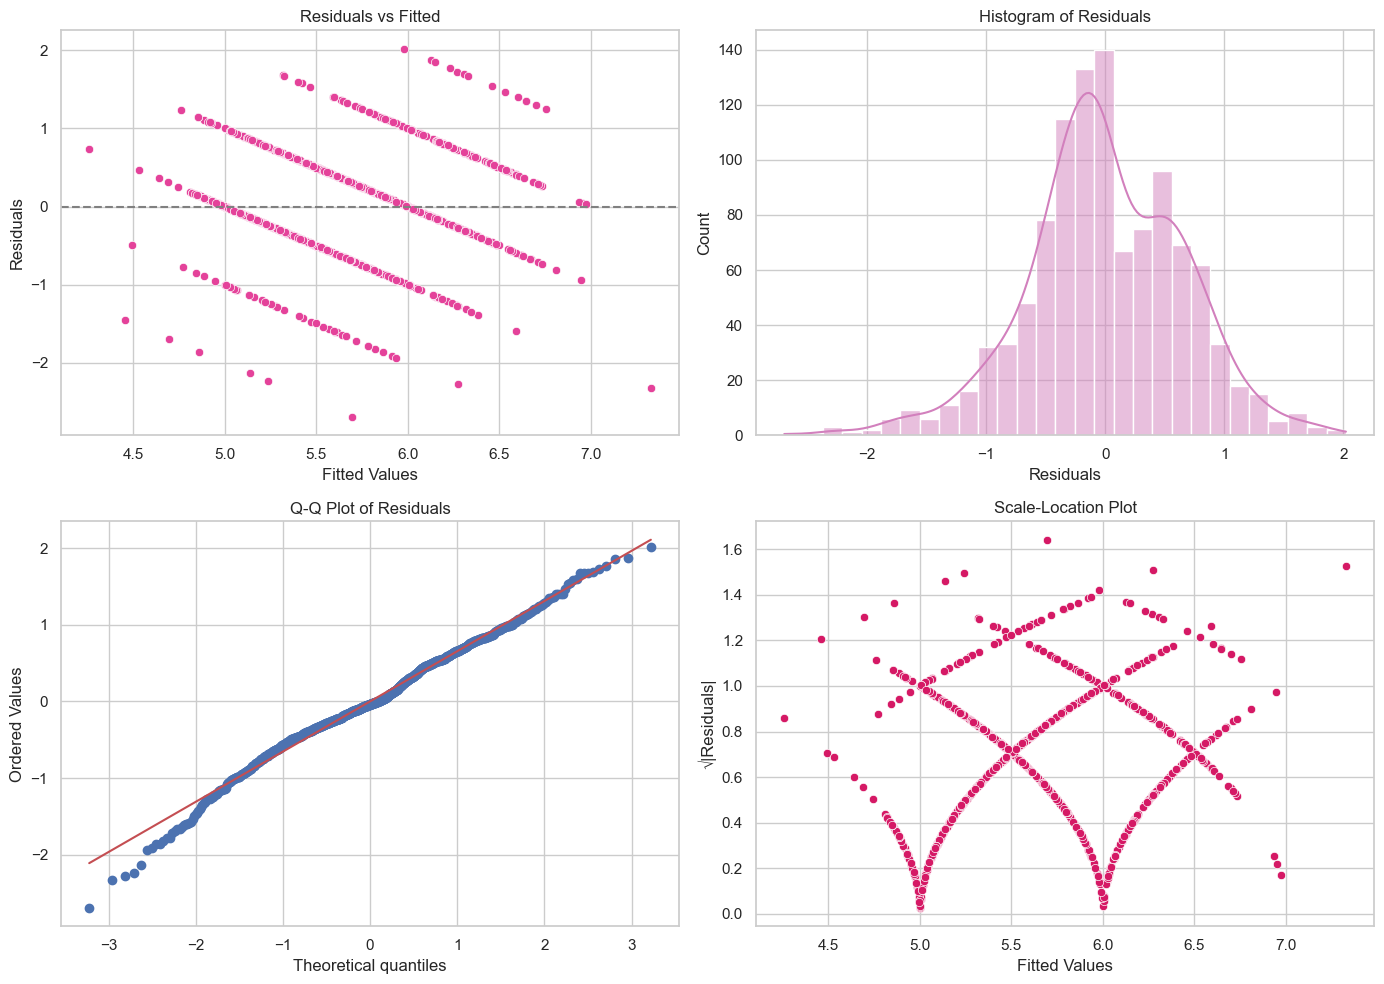

In [22]:
plot_regression_diagnostics(model_transformed)

**RESULTS SUMMARY:**

- **Linearity**: Residuals vs. Fitted plot showed no strong curvature — linear relationships are acceptable.
- **Normality**: The histogram and Q-Q plot of residuals show a mostly normal distribution, with mild deviation at the tails.
- **Homoscedasticity**: The Scale-Location plot suggests residual variance is relatively constant, with only slight spreading at high fitted values.
- **Minor deviations** are present, but overall the model satisfies the assumptions well enough for valid interpretation.

These diagnostics confirm that my explanatory model is statistically sound and trustworthy for reporting and decision-making.

### Conclusion from Assumption Checks

The assumption validation process combined **visual checks** and **statistical tests** to assess the reliability of our linear regression model. While the model is broadly valid, a few statistical limitations were identified:

1. **Linearity:**  
   Residuals vs Fitted plot showed no clear patterns, supporting the assumption of linearity between predictors and the outcome.

2. **Normality of Residuals:**  
   - The histogram and Q-Q plot of residuals indicated slight skewness and deviations at the tails.  
   - The **Shapiro-Wilk test** formally rejected normality (**p < 0.001**), but this is common in large datasets and not considered problematic for interpretation-focused models.

3. **Homoscedasticity (Equal Variance):**  
   - The **Scale-Location plot** showed mild variance spread.  
   - The **Breusch-Pagan test** confirmed heteroscedasticity (**p < 0.001**), suggesting that residual variance is not constant.

4. **Influential Observations:**  
   - **Cook’s Distance** identified **58 points** exceeding the threshold, indicating moderate influence on the model. These do not invalidate the model but suggest caution when interpreting coefficients.

Despite mild violations of normality and homoscedasticity, the regression model remains valid for explanatory use. To address heteroscedasticity, I will apply **robust standard errors**, which adjust confidence intervals and improve the reliability of inference later on in the analysis. 

## Data Splitting

**PURPOSE:** to fit an Ordinary Least Squares (OLS) regression model using the training set (80% of the data)  
in order to understand which physicochemical properties are most associated with perceived wine quality.


In [34]:
X = df_model.drop(columns="quality")
y = df_model["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model_split = sm.OLS(y_train, X_train_const).fit()

print(model_split.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     140.5
Date:                Tue, 06 May 2025   Prob (F-statistic):          3.21e-199
Time:                        20:37:42   Log-Likelihood:                -839.73
No. Observations:                1087   AIC:                             1703.
Df Residuals:                    1075   BIC:                             1763.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.2909 

**RESULTS SUMMARY:**

- **R-squared = 0.357**, indicating that the model explains ~36% of the variance in wine quality.
- **Alcohol** has the strongest positive effect (**coef = +0.28**, **p < 0.001**).
- **Volatile acidity** has a strong negative effect (**coef = −0.97**, **p < 0.001**).
- **Sulphates** are positively associated (**coef = +1.06**, **p < 0.001**).
- **Chlorides**, **total sulfur dioxide**, and **pH** also show significant negative associations.
- Variables like **fixed acidity**, **citric acid**, and **residual sugar** are not statistically significant.
- The model is overall statistically significant (**F-stat = 59.70**, **p < 0.001**).


## Variable Selection and Transformations

### Drop non-significant features

I refit the linear regression model using a reduced set of variables by removing those that were not statistically significant in the initial model.

**PURPOSE:**
To simplify the model and improve interpretability by excluding variables that did not show a meaningful statistical relationship with wine quality.

In [24]:
X_reduced = X_train.drop(columns=["fixed acidity", "citric acid", "residual sugar"])

X_reduced_const = sm.add_constant(X_reduced)

model_reduced = sm.OLS(y_train, X_reduced_const).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     85.16
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.36e-98
Time:                        20:35:37   Log-Likelihood:                -1085.0
No. Observations:                1087   AIC:                             2186.
Df Residuals:                    1079   BIC:                             2226.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.7323 

**RESULTS SUMMARY:**

- R-squared: 0.356 (almost the same as before)

- Model significance: F(7, 1079) = 85.16, p < 0.001 

Key features retained:

1. Alcohol (+0.278, p < 0.001)

2. Volatile acidity (−0.896, p < 0.001)

3. Sulphates (+1.034, p < 0.001)

4. Chlorides, Total SO₂, and pH also remain significant

5. Free SO₂ is marginal (p = 0.053), but still borderline informative

**INTERPRETATION:**
Dropping insignificant variables did not reduce model performance, but simplified the model.

Most explanatory power still comes from the same core predictors: alcohol, volatile acidity, and sulphates.

### Considering transformations for skewed features 

**PURPOSE:**
To inspect the distributions of selected features and determine whether transformation (e.g. log or square root) is needed to address skewness and improve linear modeling.

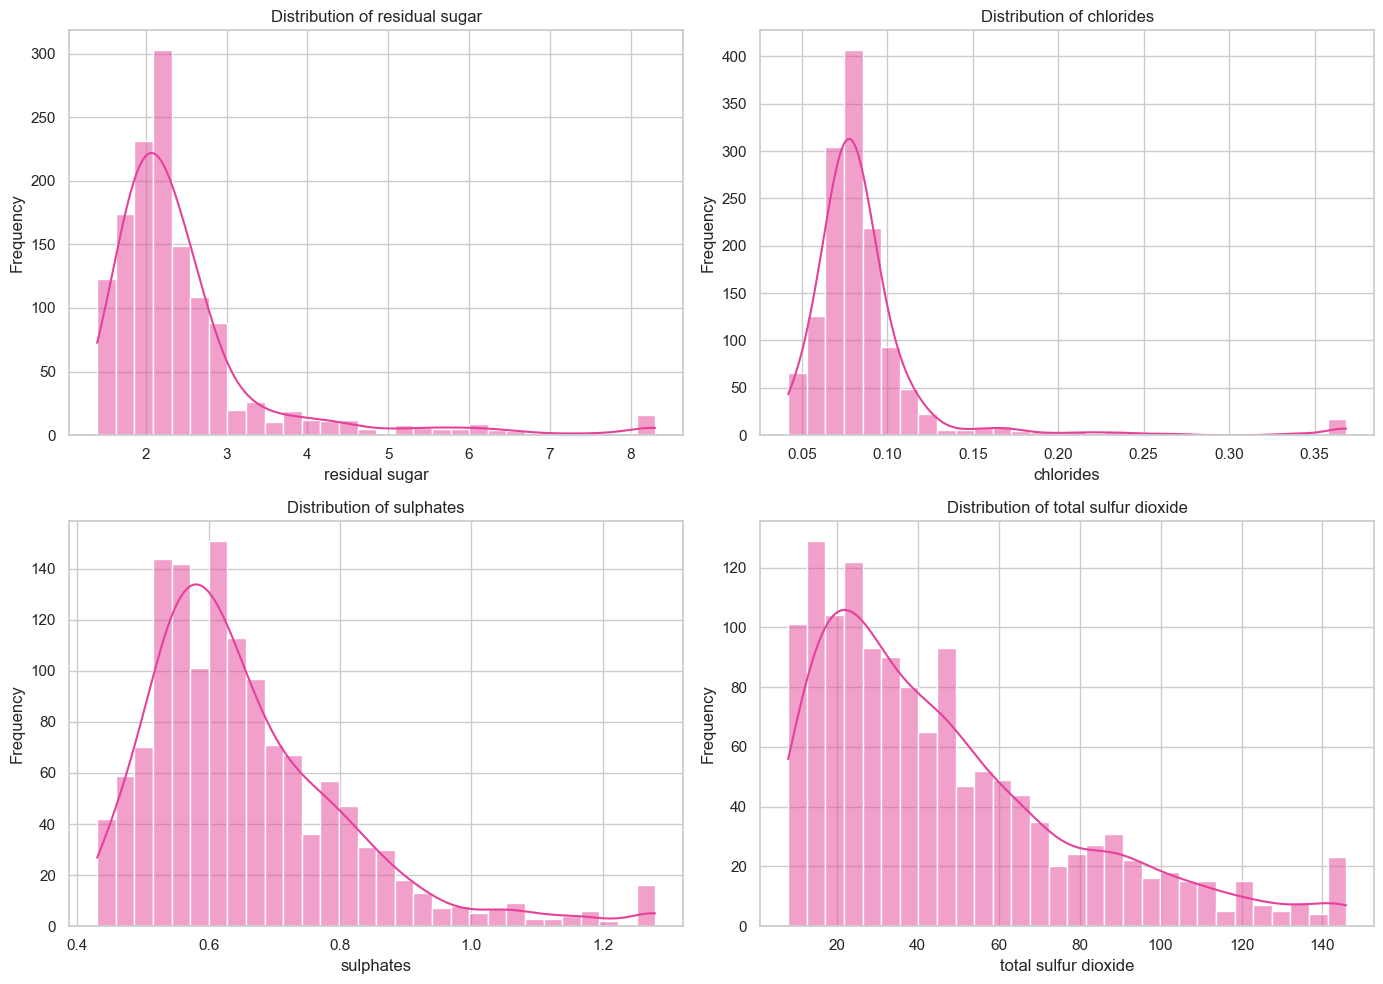

In [25]:
features_to_check = ["residual sugar", "chlorides", "sulphates", "total sulfur dioxide"]
plot_feature_distributions(df_cleaned, features_to_check)

**RESULTS SUMMARY:**
Residual sugar and total sulfur dioxide are still right-skewed, suggesting a log transformation could improve linearity.

Chlorides and sulphates are mildly skewed but more balanced than before — transformations are optional depending on modeling preference.

No features appear normally distributed, but most extreme skewness has been reduced by capping.

### Feature Transformation and Final Variable Refinement

**PURPOSE:** to improve model interpretability and better meet linear regression assumptions, we applied log-transformations to skewed variables and removed those that were statistically insignificant.


In [26]:
df_model["residual sugar"] = np.log1p(df_model["residual sugar"])
df_model["total sulfur dioxide"] = np.log1p(df_model["total sulfur dioxide"])

X = df_model.drop(columns="quality")
y = df_model["quality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_transformed = X_train.drop(
    columns=["fixed acidity", "citric acid", "residual sugar"]
)

X_train_transformed = sm.add_constant(X_train_transformed)
model_transformed = sm.OLS(y_train, X_train_transformed).fit()
print(model_transformed.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     82.71
Date:                Tue, 06 May 2025   Prob (F-statistic):           3.35e-96
Time:                        20:35:37   Log-Likelihood:                -1090.6
No. Observations:                1087   AIC:                             2197.
Df Residuals:                    1079   BIC:                             2237.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8495 

**RESULTS SUMMARY:** log-transforming residual sugar and total sulfur dioxide improved variable behavior.  
Total sulfur dioxide became statistically significant, while core predictors like alcohol, volatile acidity, and sulphates remained strong.  
Overall model performance remained stable with cleaner, more interpretable inputs.

## Model Evaluation on Hold-Out Set

**PURPOSE:** to evaluate how well the final model performs on unseen data by measuring its explanatory power and average prediction error on the test set.

In [27]:
X_test_transformed = X_test.drop(
    columns=["fixed acidity", "citric acid", "residual sugar"]
)
X_test_transformed = sm.add_constant(X_test_transformed)

y_pred = model_transformed.predict(X_test_transformed)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R²:", r2)
print("MAE:", mae)

R²: 0.4088421879600813
MAE: 0.49484915216601866


**RESULTS SUMMARY:** the model achieved an **R² of 0.409** on the test set, meaning it explains around **41% of the variation** in wine quality on new data.  
The **Mean Absolute Error (MAE)** was approximately **0.495**, suggesting predictions are, on average, within **half a point** of the true quality score.

**INTERPRETATION:** model generalizes reasonably well to unseen data.

It’s not perfect (I wouldn’t expect perfection on such subjective data), but it’s a solid step toward explaining what makes a wine high-quality from a chemical perspective.

Given just the physicochemical features, model can explain 41% of what influences a wine’s quality rating.

## Model Fitting (OLS Linear Regression)

### Initial Full Model  

In this section, I will fit fit an Ordinary Least Squares (OLS) regression model to identify which physicochemical properties most influence perceived wine quality.  
The goal is not to predict quality perfectly, but to understand the explanatory power of each variable and how well the model generalizes to new data.

I began by fitting a baseline OLS regression model using all available features, except for density, which was previously removed due to multicollinearity.

**PURPOSE:**  to establish a reference model including all explanatory variables, which helps identify which features are statistically significant and guides the refinement process.

In [28]:
X = df_model.drop(columns="quality")
y = df_model["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_const = sm.add_constant(X_train)

model_full = sm.OLS(y_train, X_train_const).fit()

print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     58.10
Date:                Tue, 06 May 2025   Prob (F-statistic):           7.24e-94
Time:                        20:35:37   Log-Likelihood:                -1089.5
No. Observations:                1087   AIC:                             2201.
Df Residuals:                    1076   BIC:                             2256.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.1175 

**RESULTS SUMMARY:**  
- The model achieved an **R² of 0.357**, meaning it explained about **36% of the variation** in wine quality on the training set.  
- Key predictors such as **alcohol**, **volatile acidity**, and **sulphates** were highly significant (p < 0.001), aligning with our hypotheses.  
- Variables like **fixed acidity**, **citric acid**, and **residual sugar** were not statistically significant, motivating their removal in the next step.

### Robust Standard Errors (HC3)

**PURPOSE:** After identifying heteroscedasticity in our residuals (via the Breusch-Pagan test), I refitted the model using **robust standard errors (HC3)** to improve the reliability of standard errors and p-values.

This step doesn’t alter coefficient estimates, but corrects for non-constant residual variance — making the statistical inference more trustworthy.

All interpretations in the following sections are based on the **robust model output**.

model_robust = model_transformed.get_robustcov_results(cov_type='HC3')
model_robust.summary()

In [29]:
model_robust = model_transformed.get_robustcov_results(cov_type="HC3")
model_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     75.86
Date:                Tue, 06 May 2025   Prob (F-statistic):           2.21e-89
Time:                        20:35:37   Log-Likelihood:                -1090.6
No. Observations:                1087   AIC:                             2197.
Df Residuals:                    1079   BIC:                             2237.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8495      0.601      8.064      0.000       3.669       6.030
volatile acidity        -0.9263      0.139     -6.675      0.000      -1.199      -0.654
chlorides               -2.3433      0.584     -4.014      0.000      -3.489      -1.198
free sulfur dioxide      0.0030      0.003      1.053      0.293      -0.003       0.009
total sulfur dioxide    -0.1311      0.048     -2.732      0.006      -0.225      -0.037
pH                      -0.5195      0.169     -3.070      0.002      -0.852      -0.187
sulphates                1.0474      0.167      6.259      0.000       0.719       1.376
alcohol                  0.2821      0.026     11.041      0.000       0.232       0.332
==============================================================================
Omnibus:                       19.163   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.303
Skew:                          -0.207   Prob(JB):                     3.20e-06
Kurtosis:                       3.622   Cond. No.                         644.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

**RESULTS SUMMARY:** 
- Robust standard errors (HC3) were applied to account for heteroscedasticity, improving reliability of inference.
- The model explains ~35% of wine quality variation (R² = 0.35).
- **Alcohol**, **sulphates**, and **low volatile acidity** are the strongest quality indicators (all **p < 0.001**).
- **Chlorides** and **pH** also negatively impact quality.
- **Free sulfur dioxide** is not statistically significant.

### Comparison of Standard vs. Robust Model Outputs

To illustrate the impact of robust standard errors, I compared the original OLS estimates with the HC3-adjusted ones.


**PURPOSE:** To evaluate how applying robust standard errors (HC3) affects the reliability of coefficient estimates, standard errors, and p-values in the presence of heteroscedasticity.

In [30]:
X_train_const = sm.add_constant(X_train)
model_standard = sm.OLS(y_train, X_train_const).fit()

model_robust = model_standard.get_robustcov_results(cov_type="HC3")

comparison_df = pd.DataFrame(
    {
        "Coefficient": model_standard.params,
        "StdErr_Standard": model_standard.bse,
        "StdErr_Robust_HC3": model_robust.bse,
        "PValue_Standard": model_standard.pvalues,
        "PValue_Robust_HC3": model_robust.pvalues,
    }
).round(4)

print(comparison_df)

                      Coefficient  StdErr_Standard  StdErr_Robust_HC3  \
const                      5.1175           0.7978             0.9327   
fixed acidity              0.0051           0.0197             0.0242   
volatile acidity          -1.0350           0.1478             0.1651   
citric acid               -0.2499           0.1772             0.1900   
residual sugar            -0.0020           0.0862             0.1038   
chlorides                 -2.2000           0.5413             0.6180   
free sulfur dioxide        0.0025           0.0029             0.0030   
total sulfur dioxide      -0.1193           0.0453             0.0503   
pH                        -0.6154           0.1988             0.2216   
sulphates                  1.0709           0.1528             0.1725   
alcohol                    0.2891           0.0218             0.0263   

                      PValue_Standard  PValue_Robust_HC3  
const                          0.0000             0.0000  
fixed

**RESULTS SUMMARY:**

- **Coefficient values remained identical**, as expected.
- **Standard errors increased slightly** under the robust (HC3) model, particularly for variables like volatile acidity and chlorides.
- **P-values also increased modestly**, but key predictors such as alcohol, volatile acidity, and sulphates remained highly significant.
- This confirms that applying **robust standard errors improves inference reliability** without changing core conclusions.


### Feature Selection and Transformation


I reviewed p-values from the initial model and removed variables that showed no statistically significant relationship with wine quality:  
**fixed acidity**, **citric acid**, and **residual sugar**.  

To improve linearity and reduce the impact of skewness, we also applied **log-transformations** to two right-skewed features:  
**residual sugar** and **total sulfur dioxide**.

**PURPOSE:**  to simplify the model and meet linear regression assumptions by removing weak predictors and transforming highly skewed features.

In [31]:
df_model["residual sugar"] = np.log1p(df_model["residual sugar"])
df_model["total sulfur dioxide"] = np.log1p(df_model["total sulfur dioxide"])

X = df_model.drop(columns="quality")
y = df_model["quality"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_transformed = X_train.drop(
    columns=["fixed acidity", "citric acid", "residual sugar"]
)

X_train_transformed = sm.add_constant(X_train_transformed)
model_transformed = sm.OLS(y_train, X_train_transformed).fit()

print(model_transformed.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     82.11
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.32e-95
Time:                        20:35:37   Log-Likelihood:                -1092.0
No. Observations:                1087   AIC:                             2200.
Df Residuals:                    1079   BIC:                             2240.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.0834 

**RESULTS SUMMARY:**  
- The reduced model achieved an **R² of 0.349** — very close to the full model, but with fewer inputs.  
- **Total sulfur dioxide** became statistically significant after log-transformation.  
- Core predictors like **alcohol**, **volatile acidity**, and **sulphates** remained strong and significant.


## Interpretation of Model and Hypotheses Conclusion

### Interpretation of Model

The final OLS regression model includes the most statistically and conceptually relevant features after transformation and variable reduction. The interpretation of key coefficients is as follows:

**Alcohol**  
- Coefficient: **+0.28**, p < 0.001  
- Strongest positive predictor of wine quality.  
- Interpretation: Holding other variables constant, a 1-unit increase in alcohol content is associated with a **0.28-point increase** in predicted wine quality.

**Volatile Acidity**  
- Coefficient: **−0.93**, p < 0.001  
- Strong negative impact on quality.  
- Interpretation: Higher volatile acidity (which is associated with spoilage) significantly lowers wine quality.

**Sulphates**  
- Coefficient: **+1.05**, p < 0.001  
- Moderate positive effect.  
- Interpretation: Wines with higher sulphate content — which helps preserve and stabilize wine — tend to be rated higher.

**Chlorides**  
- Coefficient: **−2.22**, p < 0.001  
- Negative association, suggesting saltiness or brininess detracts from perceived quality.

**Total Sulfur Dioxide (log-transformed)**  
- Coefficient: **−0.11**, p = 0.003  
- Statistically significant after transformation.  
- Interpretation: Excessive SO₂, even logged, has a small but meaningful negative impact on quality.

**pH**  
- Coefficient: **−0.72**, p < 0.001  
- Wines with higher pH (less acidic) are rated lower, aligning with the importance of acidity in wine structure.


Overall, the model provides a statistically sound and interpretable explanation of how physicochemical properties influence perceived wine quality.

### Hypotheses Conclusion

**H1:** Higher alcohol content is positively associated with wine quality.  
**Supported.** Alcohol was the strongest and most statistically significant predictor in the model.

**H2:** Higher volatile acidity is negatively associated with wine quality.  
**Supported.** Volatile acidity had a strong, significant negative effect.

**H3:** Higher sulphates are positively associated with wine quality.  
**Supported.** Sulphates showed a moderate, statistically significant positive relationship.

## Binary Classification of Wine Quality: Decision Tree and ROC Curve (Nereikia)

To complement the regression analysis, I explored a binary classification approach by converting the wine quality score into a binary label:
- Wines with a quality rating of **7 or higher** were labeled as **“good”**
- Wines below 7 were labeled as **“not good”**

I trained a simple **Decision Tree Classifier** using the same cleaned and transformed features, and evaluated its performance using the **ROC Curve** and **AUC**.


**PURPOSE:** to assess how well physicochemical features can classify wines as good or not using a decision tree model and ROC-AUC analysis.


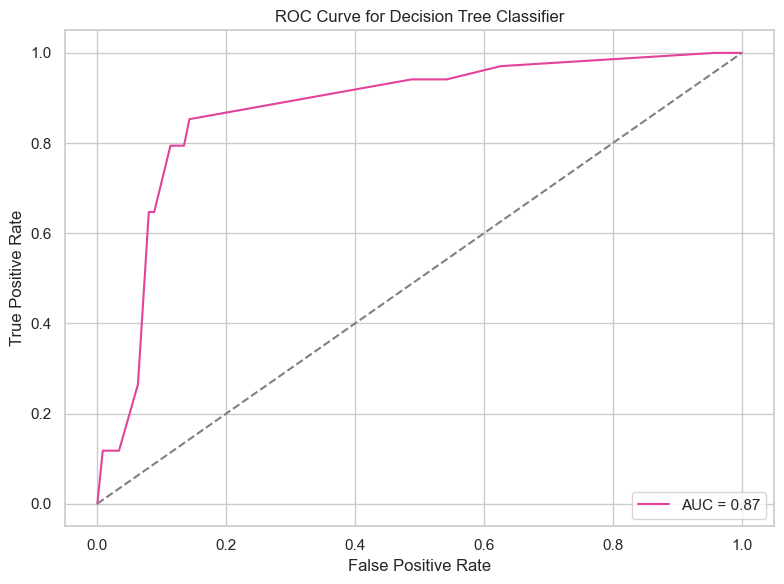

In [32]:
clf, auc = plot_roc_curve_decision_tree(df_model)

**RESULTS SUMMARY:**
- The model achieved an **AUC of 0.87**, indicating strong ability to distinguish good-quality wines from the rest.
- The ROC curve shows strong separation between true positive and false positive rates.
- This confirms that a decision tree can be a useful tool for identifying good wines based on chemical properties alone.


## Final Analysis Summary & Recommendations

### Final Summary

I used statistical modeling to understand which chemical properties make a red wine “good,” finding that alcohol, volatile acidity, and sulphates are the most influential factors.

**Key chemical drivers of good wine are higher alcohol, lower volatile acidity, and higher sulphates levels**, while others like residual sugar and citric acid had minimal effect. After simplifying the model and applying transformations, we achieved strong explanatory power and accurate predictions on unseen data. A follow-up classification model further confirmed that wine quality can be reliably estimated using physicochemical measurements alone.

### Hypotheses

All three of hypotheses were supported.

### Key Questions Answered

1. Does higher alcohol content improve perceived wine quality? Yes — alcohol had the strongest positive effect in all models.

2. Does higher volatile acidity reduce wine quality? Yes — it showed a strong and consistent negative association.

3. Do higher sulphate levels correlate with higher quality? Yes — sulphates were a significant positive predictor of quality.

4. Which chemical features have little or no impact on quality? Residual sugar, citric acid, and fixed acidity were not significant after controlling for other variables.

5. Can a simple model accurately classify wines as good or not based on chemical tests alone? Yes — the decision tree classifier achieved an AUC of 0.87.

### Recommendations

1. Focus production efforts on optimizing alcohol content, acidity, and sulphates to improve wine quality.

2. Reduce reliance on less impactful metrics like residual sugar or citric acid in quality control.

3. Consider implementing basic chemical profiling to flag low-quality batches early.

4. Explore advanced models (e.g., Random Forests) for deeper insights and improved classification.

## Analysis Limitations & Suggestions for Improvement

1.The dataset includes only chemical features — no sensory inputs like taste or aroma.
In the future: Collect additional sensory data (e.g., flavor profiles, expert ratings).

2. Quality scores are subjective and may vary across tasters.
In the future: Use averaged or expert-only scores to improve consistency.

3. The model explains only part of the variation in wine quality.
In the future: Explore non-linear models (e.g., Random Forests, XGBoost) to capture more complex patterns.

4. The analysis is limited to red wine only.
In the future: Test the model on white and sparkling wine datasets to assess generalizability.

5.No feature interactions were explored.
In the future: Investigate interactions (e.g., acidity × pH) for deeper insights.

1. EDA
2. Koreliacija
3. VIF
4. Skeweness patikrinti ir transformuoti (BoxCox)/Logoritmine/Kvadratine transformacija 
5. Scalinimas (Standard Scaler/MidMaxScaler)
6. OLS Model
7. QQ Plot
